# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы ("Ультра" и "Смарт"). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не требуется.

Необходимо построить модель с значением *accuracy* более 0.75 и проверить ее значение на тестовой выборке.

**Ход исследования:**
1. Предварительный обзор данных.
2. Разделение данных.
3. Обучение и настройка модели.
4. Тестирование модели.
5. Проверка на вменяемость.
6. Общий вывод.

## Откройте и изучите файл

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv('/yandex/practicum/datas/users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
* сalls — количество звонков,
* minutes — суммарная длительность звонков в минутах,
* messages — количество sms-сообщений,
* mb_used — израсходованный интернет-трафик в Мб,
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Всего в данных находится 3214 объектов с информацией о пользователе. Пропущенных значений нет.

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.0000,62.000,82.0000,244.00
minutes,3214.0,438.208787,234.569872,0.0,274.5750,430.600,571.9275,1632.06
messages,3214.0,38.281269,36.148326,0.0,9.0000,30.000,57.0000,224.00
mb_used,3214.0,17207.673836,7570.968246,0.0,12491.9025,16943.235,21424.7000,49745.73
is_ultra,3214.0,0.306472,0.461100,0.0,0.0000,0.000,1.0000,1.00


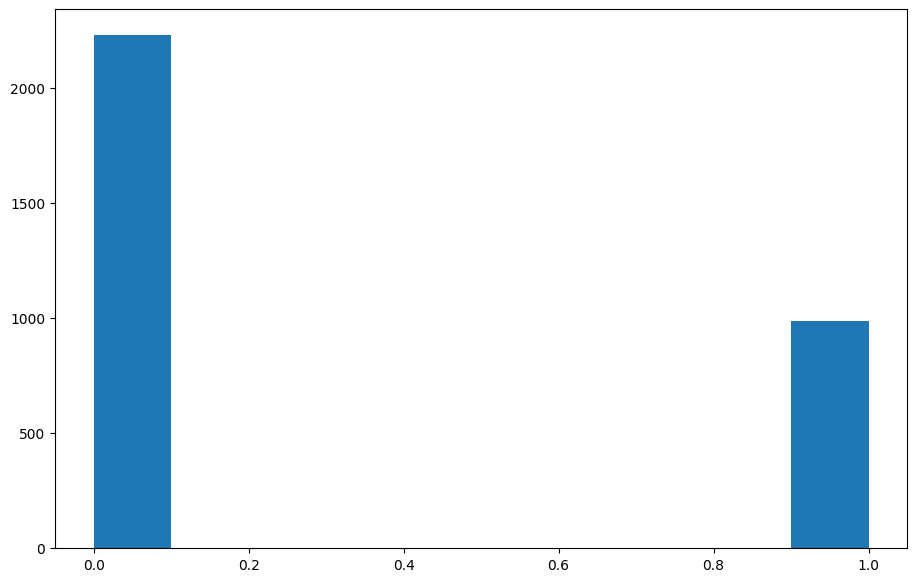

In [6]:
df['is_ultra'].hist(figsize=(11,7), grid=False);

Пользователей тарифа "смарт" в два раза больше, чем пользователей "ультра".

Целевой признак находится в колонке `is_ultra`. Всего у этого признака может быть два значения (1 или 0), поэтому решается задача бинарной классификации. Для этого воспользуемся тремя моделями машинного обучения: дерево решений, случайный лес и линейная регрессия. А метрикой accuracy определим какой из моделей справляется с задачей лучше. Проверка будет на тестовой выборке.

## Разбейте данные на выборки

Так как отсутствуют тестовые данные, разделим имеющийся датасет на следующие выборки в соотношении 3:1:1: обучающая (60%), валидационная (20%) и тестовая(20%). 

In [7]:
# разделим датасет на тестовую и тренировочную
df_train, df_test = train_test_split(df, test_size=0.4, random_state=42)
# в валидационную выборку запишем половину данных из тестовой
df_test, df_valid = train_test_split(df_test, test_size=0.5, random_state=42)

# отделим целевой признак от других в каждом получившимся датафрейме
features_train = df_train.drop('is_ultra', axis=1)
target_train = df_train['is_ultra']

features_test = df_test.drop('is_ultra', axis=1)
target_test = df_test['is_ultra']

features_valid = df_valid.drop('is_ultra', axis=1)
target_valid = df_valid['is_ultra']

In [8]:
#check
dfs = [features_train, target_train, features_test, target_test, features_valid, target_valid]

for df in dfs:
    print(df.shape)

(1928, 4)
(1928,)
(643, 4)
(643,)
(643, 4)
(643,)


## Исследуйте модели

Для исследования моделей потребуются тренировочные и валидационные данные. На основе этих данных подберем для каждой модели наилучшие гиперпараметры, а метрикой `accuracy` оценим качество.

Для автоматизации поиска оптимальных гиперпараметров модели машинного обучения в sklearn можно использовать метод GridSearchCV из модуля model_selection. 

### Decision Tree

Для модели машинного обучения "дерево решений" настроим следующие гиперпараметры:

- `max_depth`: максимальная глубина дерева.
- `splitter`: 'best', 'random'.
- `min_samples_split`: минимальное количество выборок, необходимых для разделения внутреннего узла дерева.
- `min_samples_leaf`: минимальное количество выборок, необходимых для создания листа дерева.
- `max_features`: количество признаков, используемых для поиска наилучшего разделения на каждом узле дерева.

In [9]:
# GridSearchCV выполняет перебор из заданных значений ключей(гиперпараметров)
# переберем значения пяти гиперпараметров, указанных ранее
clf = GridSearchCV(DecisionTreeClassifier(random_state=42), {
    'max_depth': range(1, 31),
    'splitter': ['best', 'random'],
    'min_samples_leaf': [1, 6],
    'min_samples_split': [2, 11]
}, cv=5, return_train_score=False)

clf.fit(features_train, target_train) # обучим на тренировочной выборке

res = pd.DataFrame(clf.cv_results_) # переведем результат в датафрейм

# и выделим значимые параметры для модели и оценку теста
res[['param_max_depth', 
     'param_splitter', 
     'param_min_samples_leaf', 
     'param_min_samples_split', 
     'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head()

,param_max_depth,param_splitter,param_min_samples_leaf,param_min_samples_split,mean_test_score
60,8,best,6,2,0.799805
62,8,best,6,11,0.799805
52,7,best,6,2,0.799275
54,7,best,6,11,0.799275
41,6,random,1,2,0.796680


In [10]:
clf.best_params_

{'max_depth': 8,
 'min_samples_leaf': 6,
 'min_samples_split': 2,
 'splitter': 'best'}

Обучим модель на тестовой выборке с оптимальными гиперпараметрами и проверим ее качество на валидационной выборке

In [11]:
model = DecisionTreeClassifier(max_depth=5, min_samples_split=11, random_state=42)

model.fit(features_train, target_train) # обучаем модель на тестовой выборке

prediction_valid = model.predict(features_valid)

result = accuracy_score(prediction_valid, target_valid) # проверяем качество модели на валидационной выборке

print("Accuracy модели на валидационной выборке:", result)

Accuracy модели на валидационной выборке: 0.8055987558320373


Модели деревьев - это модели, которые легче всего переобучаются. Чем больше глубина дерева, тем сильнее модель переобучается. Поэтому оптимальная с точки зрения качества модель имеет небольшую глубину.

### Random Forest

Если в предыдущей модели строится одно дерево решений, то для модели RF(Random forest) строится несколько деревьев, а окончательным результатом будет среднее значение ответов каждого дерева. В отличие от Random Tree, случайный лес помогает избежать переобучения.

Для модели "случайный лес" главным гиперпараметром является n_estimators — число «деревьев» в «случайном лесу». Чем больше значение числа деревьев, тем дольше обучается модель и тем лучше результат.


Гиперпараметры модели случайного леса в sklearn, которые будем подбирать:

- `n_estimators`: количество деревьев в лесу.
- `max_depth`: максимальная глубина дерева.
- `min_samples_split`: минимальное количество выборок, необходимых для разделения внутреннего узла дерева.
- `min_samples_leaf`: минимальное количество выборок, необходимых для создания листа дерева.
- `max_features`: количество признаков, используемых для поиска наилучшего разделения на каждом узле дерева.
- `bootstrap`: булевый параметр, указывающий, следует ли использовать бутстрэп-выборку (случайную выборку с возвращением) при обучении каждого дерева.

In [12]:
# аналогичным методом подбираем гиперпараметры

clf = GridSearchCV(RandomForestClassifier(random_state=42), {
    'n_estimators': range(2, 8),
    'max_depth': range(1, 11),
    'min_samples_leaf': [1, 6],
    'min_samples_split': [2, 11]
}, cv=5, return_train_score=False)

clf.fit(features_train, target_train)
res = pd.DataFrame(clf.cv_results_) 
(
res[['param_max_depth', 
     'param_n_estimators', 
     'param_min_samples_leaf', 
     'param_min_samples_split',
     'mean_test_score']]
    .sort_values(by='mean_test_score', ascending=False)
    .head()
)

,param_max_depth,param_n_estimators,param_min_samples_leaf,param_min_samples_split,mean_test_score
189,8,5,6,11,0.810173
183,8,5,6,2,0.810173
208,9,6,6,2,0.807582
214,9,6,6,11,0.807582
209,9,7,6,2,0.807581


In [13]:
clf.best_params_

{'max_depth': 8,
 'min_samples_leaf': 6,
 'min_samples_split': 2,
 'n_estimators': 5}

In [14]:
model = RandomForestClassifier(random_state=42, 
                               max_depth=8,
                               min_samples_leaf=6, 
                               min_samples_split=2, 
                               n_estimators=5)
model.fit(features_train, target_train) # обучаем на тренировочной выборке
prediction_valid = model.predict(features_valid)
result = accuracy_score(prediction_valid, target_valid) # качество определяем на валидационной
print("Accuracy модели на валидационной выборке:", result)

Accuracy модели на валидационной выборке: 0.8118195956454122


### Logistic Regression

Важными гиперпараметрами для логистической регрессии являются `penalty`, `C`, `class_weight`, `solver`. `penalty` и `C` управляют регуляризацией для предотвращения переобучения модели. `class_weight` позволяет учесть баланс классов. `solver` задает вид оптимизатора.

In [15]:
clf = GridSearchCV(LogisticRegression(random_state=42), {
    'max_iter' : [100, 1000,2500]
    }, cv=3, return_train_score=False)

clf.fit(features_train, target_train)
res = pd.DataFrame(clf.cv_results_) 

In [16]:
(
res[['param_max_iter',
    'mean_test_score']]
    .sort_values(by='mean_test_score', ascending=False)
    .head()
)

,param_max_iter,mean_test_score
0,100,0.728745
1,1000,0.728745
2,2500,0.728745


In [17]:
clf.best_params_

{'max_iter': 100}

In [18]:
model = LogisticRegression(random_state=42, max_iter=100, penalty='l2')

model.fit(features_train, target_train) # обучаем на тренировочной выборке

prediction_valid = model.predict(features_valid)

result = accuracy_score(prediction_valid, target_valid) # качество определяем на валидационной

print("Accuracy модели на валидационной выборке:", result)



Accuracy модели на валидационной выборке: 0.7682737169517885


Благодаря своего эффективного и простого алгоритма логистическая регрессия не требует больших вычислительных мощностей, прост в реализации, легко интерпретируется и широко используется аналитиками данных и учеными. 

Но эта модель плохо работает с большими данными, большим количеством признаков, а так же с признаками, которые плохо коррелируют с целевым признаком.

Среди трех алгоритмов машинного обучения лучший результат показал "случайный лес". Проверим модель на тестовой выборке

## Проверка модели на тестовой выборке

Random Forest и Decision Tree показали примерно одинаковые результат. Проверим эти модели на тестовой выборке.

In [19]:
model = DecisionTreeClassifier(max_depth=5, min_samples_split=11, random_state=42)
model.fit(features_train, target_train) 
prediction_test = model.predict(features_test)
result = accuracy_score(prediction_test, target_test) 
print("Accuracy модели на валидационной выборке:", result)

Accuracy модели на валидационной выборке: 0.7729393468118196


In [20]:
model = RandomForestClassifier(random_state=42, 
                               max_depth=8,
                               min_samples_leaf=6, 
                               min_samples_split=2, 
                               n_estimators=5)
model.fit(features_train, target_train) 
prediction_test = model.predict(features_test)
result = accuracy_score(prediction_test, target_test) 
print("Accuracy модели на валидационной выборке:", result)

Accuracy модели на валидационной выборке: 0.7978227060653188


Модель случайного леса показала более точные результаты. Примем ее как основную.

## Проверка модели на адекватность

Модель вменяема, если она умнее тривиальной модели и лучше способа, который использовался раньше. Тривиальной моделью может быть предсказание случайным, или средним (возможно с группировкой по каким-то признакам), или последним наблюдаемым значением (для временных рядов) или наиболее частым классом. 

Воспользуемся DummyClassifier из библиотеки sklearn, она представляет с собой простейшую модель, которая всегда предсказывает наиболее часто встречающийся класс. Проверим эту модель на тестовой выборке и сравним точность baseline модели и более сложной, которую выбрали в качество основной.

В методе есть параметр `strategy`, на основе которой простая модель предсказывает результаты, будем менять этот параметр. 

In [21]:
strat = ['most_frequent', 'prior', 'stratified', 'uniform'] # стратегия подбора результатов простейшей модели
for strategy in strat:
    model = DummyClassifier(random_state=42, strategy=strategy)
    model.fit(features_train, target_train)
    prediction_test = model.predict(features_test)
    result = accuracy_score(prediction_test, target_test)
    print('Гиперпараметр strategy:', strategy)
    print('Точность классификации', result)
    print()

Гиперпараметр strategy: most_frequent
Точность классификации 0.6936236391912908

Гиперпараметр strategy: prior
Точность классификации 0.6936236391912908

Гиперпараметр strategy: stratified
Точность классификации 0.5940902021772939

Гиперпараметр strategy: uniform
Точность классификации 0.5194401244167963



Лучший результат простейшем модели почти 70%, что меньше чем у более сложной.

## Общий вывод


Задача состояло в том, чтобы определить какой из тарифов подходит пользователю по имеющимся данным поведения этих клиентов. Для этого были выполнены следующие шаги:

1. Разделили данные на тренировочную, валидационную и тестовую.
2. Выделили три алгоритма машинного обучения и подобрали наиболее оптимальные гиперпараметры.
3. Качество модели проверяли по метрике Accuracy.
4. Дополнительно проверили качество модели на тестовой выборке.

В результате исследования лучший результат показала модель Random Forest Classifier c `Accuracy` = 0.81.